# Generate Listing Co-Occurrences as Collaborative Data
Across all users web activity, find what listings users tended to view right before and two after the current one.

Use this information as an indication of user journey, exploration and intent for training models.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

## Web Data

Read in Web Interaction Data - already filtered specifically to interactions available for 5.5k LA listings

From `Load_Web_Data.ipynb`

In [ ]:
df = pd.read_pickle("all_webdata_filtered.pkl")
df.rename({'rexurl':'rexUrl'},axis=1,inplace=True)
print(df.shape)

In [ ]:
print('unique users', df['ip'].nunique())
print('unique listings', df['rexUrl'].nunique())
print('total web interactions, LA',df.shape)

unique users 92071
unique listings 533
total web interactions, LA (4617883, 6)


In [ ]:
df_web_la = df.copy()

# Convert eventstamp to datetime
df_web_la['event_stamp'] = pd.to_datetime(df_web_la['event_stamp'])

#sort by ip and eventstamp
df_web_la.sort_values(['ip','event_stamp'],ascending=True,inplace=True)

### Visualize number of interactions by ip

In [ ]:
houses_per_ip = df_web_la.groupby('ip')['rexUrl'].aggregate('nunique').value_counts(normalize=True)

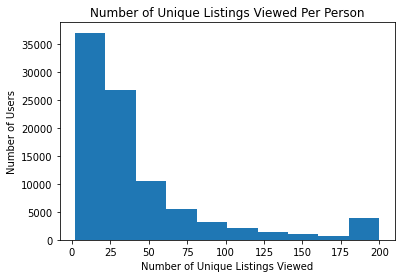

In [ ]:
plt.hist(np.clip(df_web_la.groupby('ip')['rexUrl'].count().values,0,200))
plt.title('Number of Unique Listings Viewed Per Person')
plt.xlabel('Number of Unique Listings Viewed')
plt.ylabel('Number of Users')
plt.show()

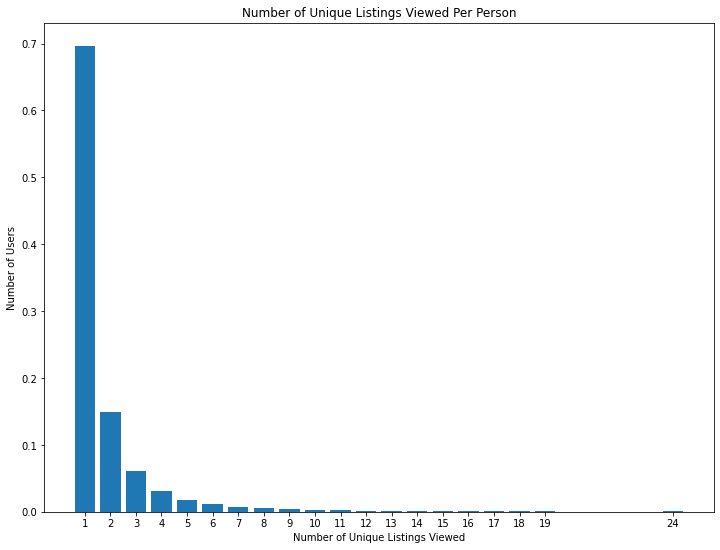

In [ ]:
# View normalized counts of the top 20 (by valuecount)
sub_houses_per_ip = houses_per_ip.head(20)
plt.figure(figsize=(12,9))
plt.bar(x=sub_houses_per_ip.index, height=sub_houses_per_ip.values)
plt.xticks(sub_houses_per_ip.index)
plt.title('Number of Unique Listings Viewed Per Person')
plt.xlabel('Number of Unique Listings Viewed')
plt.ylabel('Number of Users')
plt.show()

### Define windows of co-occurrence

In [ ]:
# get the ordered set of unique listings viewed by each user

from collections import OrderedDict

rex_list_each_user = df_web_la.groupby('ip')['rexUrl'].apply(lambda x: list(OrderedDict.fromkeys(x))).values.tolist()
rex_list_each_user[:10]

[['28710-indies-ln-canyon-country'],
 ['23552-park-south-st'],
 ['9235-garibaldi-ave'],
 ['9323-alcott-st-apt-101', '1050-trevecca-pl'],
 ['3501-knoll-crest-ave'],
 ['2463-corralitas-dr'],
 ['1050-trevecca-pl', '9735-baden-ave'],
 ['14919-cadillac-ct'],
 ['1534-amherst-ave-apt-302'],
 ['850-e-ocean-blvd-apt-607']]

In [ ]:
# the length of the list (of lists) should be the number of users
print(len(rex_list_each_user))
print(df_web_la.ip.nunique())

92071
92071


In [ ]:
# Get a dictionary of listings each house Co-Occured with (within a window)

from collections import Counter
from collections import defaultdict

window_occurences = defaultdict(Counter)

#loop through of all viewings for a user
for viewings_user_curr in rex_list_each_user:
  #for each house in list of viewings
    for i, listing in enumerate(viewings_user_curr):
      # Set window as one before and two ahead
      window = viewings_user_curr[max(0,i-1):i+3].copy()
      #remove self (anchor)
      while listing in window:
        window.remove(listing) 
      
      # update the dict of current anchor listing with this window of co-occurances
      window_occurences[listing].update(window)

In [ ]:
# Remove empty dict elements (when listing didn't co-occur with any)
window_occurences = {k: v for k, v in dict(window_occurences).items() if v}

In [ ]:
print(len(window_occurences), 'listings ever co-occured with others')

504 listings ever co-occured with others


In [ ]:
# Gutcheck how many janette street (for example) co-occurred with
len(window_occurences['1017-janette-st'])

85

In [ ]:
# Function to visualize example co-occurrences
def view_co_ocs(anchor,df_in):
  pd.options.display.float_format = '{:,.1f}'.format
  df = df_in.copy()
  df['sqft'] = np.exp(df['log_sqft'])
  df['price'] = np.exp(df['log_price'])
  df['total_rooms'] = np.exp(df['log_total_rooms'])
  cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

  cooc_df = pd.DataFrame.from_dict(dict(window_occurences[anchor]),orient='index').reset_index().rename({'index':'rex_url',0:'cooc_count'},axis=1)

  cooc_data = cooc_df.merge(df,on='rex_url',how='left')[cols+['cooc_count']].set_index('rex_url')

  cooc_data.sort_values('cooc_count',ascending=False,inplace=True)
  anchor_row = df[df.rex_url==anchor][cols].set_index('rex_url')


  return pd.concat([anchor_row, cooc_data])

converse_street_coocs = view_co_ocs('4799-converse-st',listing_data)
converse_street_coocs['ppsqft'] = converse_street_coocs['price']/converse_street_coocs['sqft']
converse_street_coocs.head(15)

# Generate Co-Occurrence Triplets (anchor, positive, negative)
To be used in Siamese NN and Random Forest

In [ ]:
all_houses = list(set(df_web_la['rexUrl']))

In [ ]:
from itertools import repeat
import random
random.seed(297)
co_occurences = window_occurences.copy()

# Creating a dictionary, where each key is a listing, and the values are a list of other houses it has appeared with
# houses that it has appeared with multiple times are repeated

listing_cooc_dict = {}
listing_neg_dict = {}

for housename in list(co_occurences.keys()):
  # Set of listings it appeared with
  appeared_with = list(co_occurences[housename].keys())

  # Ordered tuple pairings of listings it appeared with
  sorted_cooc_tuples = co_occurences[housename].most_common()
  cooc_rep_list = []
  for other_listing, count_together in sorted_cooc_tuples:
    if(other_listing==housename):
      continue
    else:
      repeated = list(repeat(other_listing,count_together))
      cooc_rep_list.extend(repeated)

  
  # Add itself to list of "appeared with"
  appeared_with.append(housename)
  
  # For every example of listing it has appeared with,
  # sample another random listing that it has NOT appeared with (equal lengths)

  # Get set of listings it didn't appear with
  didnt_appear_with = list(set(all_houses)-set(appeared_with))
  
  n_appearswith = len(cooc_rep_list)
  n_didntappearwith = len(didnt_appear_with)
  
  #if appeared with more than didnt appear with, swap them so you can still sample
  if(n_didntappearwith<n_appearswith):
    n_appearswith = n_didntappearwith

  sample_nocooc = random.sample(didnt_appear_with,n_appearswith)

  #Save positive and negative co-occurrences into dictionary for current anchor
  listing_cooc_dict[housename] = cooc_rep_list
  listing_neg_dict[housename] = sample_nocooc


In [ ]:
# Given positive/negative co-occurrences above,
# Compile a list of triplets
triplets = []
for listing in listing_cooc_dict.keys():
  #if list is empty (no coocs), dont add it
  if not listing_cooc_dict[listing]:
    continue
  for pos, neg in zip(listing_cooc_dict[listing],listing_neg_dict[listing]):
    triplets.append([listing,pos,neg])

In [ ]:
triplets_url = pd.DataFrame(triplets, columns = ['anchor', 'positive','negative'])
print(triplets_url.shape)
triplets_url.tail(10)

(81584, 3)


,anchor,positive,negative
81574,18543-victory-blvd,1330-s-ynez-ave,3020-hollycrest-dr
81575,2307-ashland-ave,8719-topanga-canyon-blvd,726-w-28th-st
81576,2307-ashland-ave,5902-finecrest-dr,15622-nahin-ln
81577,2307-ashland-ave,1417-e-maple-st,4335-penca-ave
81578,28710-indies-ln,16321-janine-dr,5861-parkmor-rd
81579,28710-indies-ln,8450-denise-ln,2738-denmead-st
81580,28710-indies-ln,1506-lynoak-dr,3427-greensward-rd
81581,14033-mar-vista-st,15225-santa-gertrudes-ave-apt-p104,15904-ocean-ln
81582,14033-mar-vista-st,945-acacia-ln,1243-8th-st
81583,14033-mar-vista-st,814-e-graves-ave,38321-bonino-dr


In [ ]:
# make sure there are never anchors which are negative or pos, or pos being negative
display(triplets_url[triplets_url.anchor==triplets_url.negative])
display(triplets_url[triplets_url.anchor==triplets_url.positive])
display(triplets_url[triplets_url.positive==triplets_url.negative])

,anchor,positive,negative


,anchor,positive,negative


,anchor,positive,negative


In [ ]:
# number of unique anchors
triplets_url.anchor.nunique()

504

In [ ]:
# Saving data for use in other notebooks

# triplets_url.to_csv("triplets_LA.csv", index=False)

# import pickle

# # save co-occurance house
# f = open("listing_cooc_dict.pkl","wb")
# pickle.dump(listing_cooc_dict,f)
# f.close()

# # save house features
# f = open("listing_dict.pkl","wb")
# pickle.dump(listing_dict,f)
# f.close()

## Case study check
Are all of the co-occurrences accounted for?

In [ ]:
triplets_url[(triplets_url.anchor=='7800-topanga-canyon-blvd-apt-201') & (triplets_url.positive=='17007-ridge-park-dr')]

,anchor,positive,negative
77805,7800-topanga-canyon-blvd-apt-201,17007-ridge-park-dr,125-s-bandini-st
77806,7800-topanga-canyon-blvd-apt-201,17007-ridge-park-dr,3110-summertime-ln


In [ ]:
# How many times does topanga appear with ridge park? Should be 2
co_occurences['7800-topanga-canyon-blvd-apt-201']['17007-ridge-park-dr']

2

In [ ]:
# The number of rows for this anchor should be the same as the number of listings in its dictionary
sum(co_occurences['7800-topanga-canyon-blvd-apt-201'].values()) == triplets_url[triplets_url.anchor=='7800-topanga-canyon-blvd-apt-201'].shape[0]

True

## Bring in processed LA listing data features
From `LA_listing_feature_engineering.ipynb`

In [ ]:
# listing_data_all = pd.read_pickle('LOG_siamese_data_11_12.pkl')
listing_data_all = pd.read_pickle('listing_data_filtered_with_img.pkl')
listing_data_all.head(2)

,rex_url,total_baths,stories,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,bedrooms,full_baths,half_baths,year_built,latitude,longitude,is_apt,hotness_score,demand_score,supply_score,ldpviews_per_property_vs_us,loc_tsne_1,loc_tsne_2,1hot_marketing_budget_LOW,1hot_marketing_budget_MEDIUM,1hot_marketing_budget_SURGE,1hot_property_type_CONDO,1hot_property_type_COOP,1hot_property_type_MULTI_FAMILY,1hot_property_type_SINGLE,1hot_property_type_TOWNHOUSE,1hot_pool_spa_types_Community Pool or Spa,1hot_pool_spa_types_Heated Pool,1hot_pool_spa_types_In Ground,1hot_pool_spa_types_No,1hot_pool_spa_types_Pool & Spa (both),1hot_pool_spa_types_Pool (yes),1hot_pool_spa_types_Spa (only),1hot_home_style_Bungalow,1hot_home_style_Cape Cod,1hot_home_style_Contemporary,1hot_home_style_Mediterranean,1hot_home_style_Modern,1hot_home_style_Other,1hot_home_style_Ranch/Rambler,1hot_home_style_Spanish,1hot_home_style_Traditional,1hot_fencing_description_Average Condition,1hot_fencing_description_Back Yard,1hot_fencing_description_Block,1hot_fencing_description_Block Wall,1hot_fencing_description_Chain Link,1hot_fencing_description_Excellent Condition,1hot_fencing_description_Good Condition,1hot_fencing_description_None,1hot_fencing_description_Other,1hot_fencing_description_Other/Remarks,1hot_fencing_description_Partial,1hot_fencing_description_Privacy,1hot_fencing_description_Stucco Wall,1hot_fencing_description_Vinyl,1hot_fencing_description_Wood,1hot_fencing_description_Wrought Iron,1hot_property_condition_Additions/Alter,1hot_property_condition_Additions/Alterations,1hot_property_condition_Building Permit,1hot_property_condition_Fixer,1hot_property_condition_Other,1hot_property_condition_Repairs Cosmetic,1hot_property_condition_Repairs Major,1hot_property_condition_Termite Clearance,1hot_property_condition_Turnkey,1hot_property_condition_Updated/Remodeled,log_price,log_sqft,log_median_listing_price,log_median_days_on_market,log_nielsen_hh_rank,log_land_sqft,log_total_rooms
0,rex1-pacific-coast-hwy,12.0,1,0,0,0,0,0,12.0,2.0,0.0,2015.0,34.023865,-118.787080,0.0,23.044945,44.348576,1.741313,0.9191,4.173980,6.034126,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,17.599700,9.350972,15.404756,5.398163,8.734077,11.860550,3.496508
1,4080-glencoe-ave-unit-316,2.0,1,0,0,0,0,0,1.0,2.0,0.0,2011.0,33.990732,-118.441965,1.0,6.741705,3.992470,9.490940,0.2721,9.119221,13.400335,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.909911,7.365180,14.143410,4.663439,7.694393,9.760541,1.609438


In [ ]:
# subset to only ones with webdata
listing_data = listing_data_all[listing_data_all.rex_url.isin(df.rexUrl)].copy()

### Triplets: Replace Listing Name with Actual Listing Features 

In [ ]:
triplets_data = triplets_url.copy()

In [ ]:
# get column names (excluding rex_url)
listing_data_cols = list(listing_data.columns)[1:]

for lsting in ['anchor','positive','negative']:
  triplets_data = triplets_data.merge(listing_data,left_on=lsting,right_on='rex_url',how='left')

  triplets_data[lsting+'_data'] = triplets_data[listing_data_cols].values.tolist()
  triplets_data.drop(list(listing_data.columns),axis=1,inplace=True)

In [ ]:
triplets_data.head()

,anchor,positive,negative,anchor_data,positive_data,negative_data
0,28710-indies-ln-canyon-country,6345-colbath-ave,1215-e-carson-st-apt-20,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, ..."
1,28710-indies-ln-canyon-country,6345-colbath-ave,7107-s-sepulveda-blvd,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ..."
2,28710-indies-ln-canyon-country,6345-colbath-ave,5625-sumner-way-unit-207,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, ..."
3,28710-indies-ln-canyon-country,6345-colbath-ave,3065-orange-ave,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ..."
4,28710-indies-ln-canyon-country,6345-colbath-ave,19414-castille-ln,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 3.0, 2.0, ..."


In [ ]:
triplets_data_w_names = triplets_data.copy()
triplets_data.drop(['anchor','positive','negative'],axis=1,inplace=True)
triplets_data.rename({'anchor_data':'anchor','positive_data':'positive','negative_data':'negative'},axis=1,inplace=True)

In [ ]:
triplets_data.head()

,anchor,positive,negative
0,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, ..."
1,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ..."
2,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, ..."
3,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ..."
4,"[3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 3.0, 3.0, ...","[2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, ...","[2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 3.0, 2.0, ..."


In [ ]:
triplets_data.shape

(81584, 3)

Save out triplets to be used in models

In [ ]:
np.save('anchor_data_w_image',np.array(triplets_data.anchor.values.tolist()))
np.save('pos_data_w_image',np.array(triplets_data.positive.values.tolist()))
np.save('neg_data_w_image',np.array(triplets_data.negative.values.tolist()))

## Use Triplets to Generate Pairs (anchor-pos, anchor-neg) for Tree Model

(keeping duplicates - effectively weighting multiple viewings)

In [ ]:
positive_pairs_w = triplets_url[['anchor','positive']].copy()
positive_pairs_w = positive_pairs_w.merge(listing_data,left_on='anchor',right_on='rex_url')
positive_pairs_w = positive_pairs_w.merge(listing_data,left_on='positive',right_on='rex_url',suffixes=('_anchor','_pair'))
positive_pairs_w.drop(['rex_url_anchor','rex_url_pair'],axis=1,inplace=True)
positive_pairs_w.shape

(81584, 170)

In [ ]:
negative_pairs_w = triplets_url[['anchor','negative']].copy()
negative_pairs_w = negative_pairs_w.merge(listing_data,left_on='anchor',right_on='rex_url')
negative_pairs_w = negative_pairs_w.merge(listing_data,left_on='negative',right_on='rex_url',suffixes=('_anchor','_pair'))
negative_pairs_w.drop(['rex_url_anchor','rex_url_pair'],axis=1,inplace=True)
negative_pairs_w.shape

(81584, 170)

In [ ]:
positive_pairs_w.to_pickle('positive_pairs_w_image.pkl')
negative_pairs_w.to_pickle('negative_pairs_w_image.pkl')